Import required libraries. In particular:

1. [*isatools*](https://github.com/ISA-tools) for experimental metadata (ISA)
2. [*ome_files*](https://github.com/ome/ome-files-py) for imaging data and metadata (OME)
3. [*biotracks*](https://github.com/CellMigStandOrg/biotracks) for cell tracking data (biotracks)

In [1]:
%matplotlib inline
import os
import xml.dom.minidom as minidom
import matplotlib.pyplot as plt
import pandas as pd
import datapackage
import ome_files
import ome_files.metadata as ofmd
import isatools.io.isatab_parser as isatab_parser
import biotracks.cmso as cmso
from biotracks.readfile import BiotracksReader

Create an `OMETIFFReader` (the file format reader for OME-TIFF files) and set it to read the [**companion OME XML**](https://github.com/CellMigStandOrg/CMSO-Samples/blob/master/UGent/BaF3/9I5TT808_F00000010.companion.ome) file for the dataset. This file contains image metadata as well as references to other files containing image data, experimental metadata and tracking metadata.

image size: 1376 x 1038


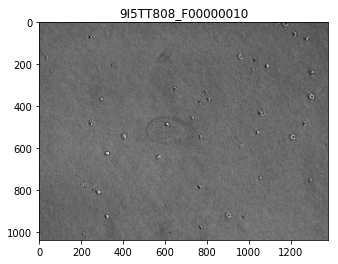

In [2]:
old_cwd = os.getcwd()
os.chdir(os.path.join("UGent", "BaF3"))
reader = ome_files.OMETIFFReader()
reader.set_id("9I5TT808_F00000010.companion.ome")
# get the first image plane as a numpy array
pixels = reader.open_array(0)
# get the OME XML metadata and core image metadata
ome_xml = reader.get_ome_xml()
meta = ofmd.OMEXMLMetadata(ome_xml)
img_count = reader.get_image_count()
H, W = reader.get_size_y(), reader.get_size_x()
print("image size: %d x %d" % (W, H))
reader.close()
plt.imshow(pixels, cmap="gray")
plt.title('9I5TT808_F00000010');

Let's get some more imaging metadata, according to the [model](https://docs.openmicroscopy.org/ome-model/5.5.7/specifications/).

In [3]:
def getText(nodelist):
    rc = []
    for node in nodelist:
        if node.nodeType == node.TEXT_NODE:
            rc.append(node.data)
    return ''.join(rc)

In [4]:
doc = minidom.parseString(ome_xml)
pixel_nodes = doc.getElementsByTagName("Pixels")
assert len(pixel_nodes) == 1
node = pixel_nodes[0]
print("physical size x: %s - physical size y: %s" % (node.getAttribute("PhysicalSizeX"), node.getAttribute("PhysicalSizeY")))

physical size x: 0.322 - physical size y: 0.322


In [5]:
image_nodes = doc.getElementsByTagName("Image")
assert len(image_nodes) == 1
image = image_nodes[0]
date = image.getElementsByTagName("AcquisitionDate")[0]
print("acquisition date: %s" % getText(date.childNodes))

acquisition date: 2013-03-25T22:05:52Z


In [6]:
description = image.getElementsByTagName("Description")[0]
print("description: %s" % getText(description.childNodes))

description: Camera 1376x1038, Controler present, Lightsource off


Get the **ISA CMSO annotations** (references to files containing experimental metadata in the ISA format, implemented via OME map annotations:

In [7]:
cmso_annotations = [_ for _ in meta.get_map_annotations() if _.Namespace == "CMSO/isa"]
assert len(cmso_annotations) == 1
ann = cmso_annotations[0]
paths = ann.Value.get("FilePath")
print(paths)

['isatab/i_Investigation.txt']


Now that we have the ISA *investigation* file, we use the [ISA tools API](http://isatools.readthedocs.io/en/latest/index.html) to get the Study and the Assay information.

In [8]:
isa_path = os.path.abspath(paths[0])  # Relative path does not work. isatools bug?
# the parse function returns an ISATabRecord object which contains investigation details
# this is top-level information like associated publications and contacts
record = isatab_parser.parse(isa_path)

inserting Protocol REF.3 at position 46
inserting Protocol REF.3 at position 46


In [9]:
print('Number of studies: {}'.format(len(record.studies)))

Number of studies: 1


In [10]:
# get the study by index and access some ISA metadata
study = record.studies[0]
print('Title of the study: {}'.format(study.metadata["Study Title"]))
print('*************************************************************')
print('Description of the study: {}'.format(study.metadata["Study Description"]))

Title of the study: Ba/F3 cell line expressing 3 distinct 2BCR-ABL constructs exposed to Rock inhibitors
*************************************************************
Description of the study: The systematic study of single-cell migration requires the availability of software for assisting data inspection, quality control and analysis. This is especially important for high-throughput experiments, where multiple biological conditions are tested in parallel. Although the field of cell migration can count on different computational tools for cell segmentation and tracking, downstream data visualization, parameter extraction and statistical analysis are still left to the user and are currently not possible within a single tool. This article presents a completely new module for the open-source, cross-platform CellMissy software for cell migration data management. This module is the first tool to focus specifically on single-cell migration data downstream of image processing. It allows fast 

In [11]:
print('Number of assays used in the study: {}'.format(len(study.assays)))

Number of assays used in the study: 1


In [12]:
# get the assay by index and access some metadata
assay = study.assays[0]
print('Assay Measurement Type: {}'.format(assay.metadata["Study Assay Measurement Type"]))
print('Assay Technology Type: {}'.format(assay.metadata["Study Assay Technology Type"]))

Assay Measurement Type: cell migration assay
Assay Technology Type: microscopy imaging


In [13]:
# have a look at the ontologies used
for ont_ref in record.ontology_refs:
    print('Ontology description: {}'.format(ont_ref.get('Term Source Description')))

Ontology description: Cell Line Ontology
Ontology description: Ontology for Biomedical Investigations
Ontology description: Units of Measurement Ontology


Get the **biotracks CMSO annotations** (references to data packages containing tracking metadata in the biotracks format), again implemented via OME map annotations:

In [14]:
cmso_annotations = [_ for _ in meta.get_map_annotations() if _.Namespace == "CMSO/dpkg"]
assert len(cmso_annotations) == 1
ann = cmso_annotations[0]
paths = ann.Value.get("FilePath")
print(paths)

['cellmia/datapackage.json', 'trackmate/datapackage.json']


Read the datapackages with the biotracks API and convert them to pandas dataframes:

In [15]:
dataframes = {}
for dp_fn in paths:
    reader = BiotracksReader(dp_fn)
    reader.read()
    df = reader.objects
    df0 = df[df[cmso.FRAME_ID] == 0]
    # populate the dict
    dataframes[dp_fn] = df0
    print("\n%s:" % dp_fn)
    print(df0.head())


cellmia/datapackage.json:
     cmso_object_id  cmso_frame_id  cmso_x_coord  cmso_y_coord
0                 0              0   1170.187500      2.187500
22               22              0   1274.867925     78.603774
56               56              0    807.500000    367.000000
156             156              0   1026.035088    180.561404
242             242              0   1040.210526    525.631579

trackmate/datapackage.json:
   cmso_object_id  cmso_frame_id  cmso_x_coord  cmso_y_coord
0            4944              0    374.808007      0.000000
1            4945              0    379.580211      5.092978
2            4946              0    393.821457     17.832669
3            4947              0    411.600018     24.898522
4            4948              0    183.139192     48.351896


In [16]:
# define a function to plot the segmented objects on top of the raw image
def plot_overlay(dp_fn, title, x_scale=1.0, y_scale=1.0):
    # get the right dataframe from the dict
    df = dataframes[dp_fn]
    x, y = x_scale * df[cmso.X_COORD].values, y_scale * df[cmso.Y_COORD].values
    plt.scatter(x=x, y=y, s=100, edgecolors='b', facecolors='none')
    plt.imshow(pixels, cmap="gray")
    plt.title(title)
    plt.xlabel(cmso.X_COORD)
    plt.ylabel(cmso.Y_COORD)
    plt.show()

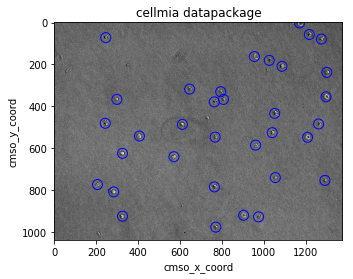

In [17]:
plot_overlay("cellmia/datapackage.json", "cellmia datapackage")

In [18]:
# trackmate outputs coordinates as physical size
doc = minidom.parseString(ome_xml)
pixel_nodes = doc.getElementsByTagName("Pixels")
assert len(pixel_nodes) == 1
node = pixel_nodes[0]
x_scale = 1 / float(node.getAttribute("PhysicalSizeX"))
y_scale = 1 / float(node.getAttribute("PhysicalSizeY"))
print('x_scale = {} \ny_scale = {}'.format(x_scale, y_scale))

x_scale = 3.1055900621118013 
y_scale = 3.1055900621118013


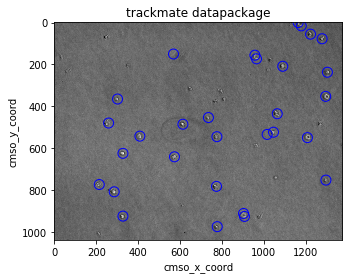

In [19]:
plot_overlay("trackmate/datapackage.json", "trackmate datapackage", x_scale, y_scale)

In [20]:
os.chdir(old_cwd)